### Student Name: Ganapathy
### Student ID: 18202799

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

# Task 1
Load bank-et1.csv into a Pandas dataframe. 

In [3]:
df = pd.read_csv('./bank_et1.csv')

Examine the first few data rows and the last few data rows. Identify an attribute that can be the target/dependable variable for 2-class classification. Follow the examples in the provided notebook “Lab 1 - Exploratory Data Analysis. ipynb ” (see section Material, Resources and Online Meetings below).

In [4]:
# Print first 10 rows of the dataframe
df.head(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,0,32,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,1,39,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,2,59,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,3,47,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,4,54,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [5]:
df.drop(columns='Unnamed: 0', inplace=True)

In [6]:
# Print first 10 rows of the dataframe
df.tail(5)

,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,20,student,single,NaN,no,2785,-2.170524,1.081071,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,28,admin.,single,secondary,no,127,0.811788,1.134496,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,81,retired,married,primary,no,1154,0.504655,0.042190,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,46,services,married,primary,no,4343,-0.965874,0.302708,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,40,entrepreneur,married,secondary,no,6403,-0.800893,1.066659,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


 Identify an attribute that can be the target/dependable variable for 2-class classification?

After examining the data, we can see that the features: default, housing, loan, contact and subscribed has 2 classes.
The unknown in this case is if the user subscribed to the loan after being contacted by the bank loan department. 
The attribute which can be the target/dependable variable for 2-class classification is subscribed which has 2 outcomes: yes or no.

In [7]:
# Print statistical summary for all numerical attributes
df.describe()

,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.751500,1413.663500,0.241951,0.485030,13.851500,292.020500,1.909500,167.896000,2.561500
std,12.723077,3131.224213,0.821604,1.075543,9.712189,221.557295,1.378862,131.754126,3.400735
min,18.000000,-980.000000,-2.632068,-2.851405,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,-0.308018,-0.274181,5.000000,146.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,0.224099,0.487082,12.000000,236.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,0.806315,1.211896,23.000000,379.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,2.961979,4.046914,31.000000,1823.000000,11.000000,854.000000,55.000000


#### Numerical variables preview:
ratio_bal_ln: The maximum ratio of balance to loan is in the range of -2.63% to 2.96% 

ratio_ln_inc: The maximum ratio of loan to income is in the range of -2.85% to 4.046%

In [8]:
nunique = df.nunique()
nunique

age               68
job               11
marital            3
education          3
default            2
balance         1274
ratio_bal_ln    2000
ratio_ln_inc    2000
housing            2
loan               2
contact            2
day               31
month             12
duration         655
campaign          11
pdays            363
previous          26
poutcome           3
subscribed         2
dtype: int64

##### Task 2
 The attribute that can be the target/dependable varibale for 2-class classifictation is "subscribed" which means whether the customer is subscribed for term deposit. This would allow bank to market the product to new customers based for term deposit products

In [9]:
df.isnull().sum()

age               0
job              10
marital           0
education       104
default           0
balance           0
ratio_bal_ln      0
ratio_ln_inc      0
housing           0
loan              0
contact         191
day               0
month             0
duration          0
campaign          0
pdays             0
previous          0
poutcome        454
subscribed        0
dtype: int64

In [10]:
df['loan'].value_counts()

no     1750
yes     250
Name: loan, dtype: int64

In [11]:
df['housing'].value_counts()

no     1037
yes     963
Name: housing, dtype: int64

In [12]:
df['contact'].value_counts()

cellular     1663
telephone     146
Name: contact, dtype: int64

##### Use at least two different plotting techniques to plot the distribution of two numerical and two categorical attributes

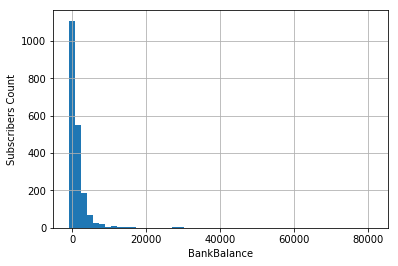

In [13]:
df['balance'].hist(bins=50)
plt.xlabel('BankBalance')
plt.ylabel('Subscribers Count')
plt.show()

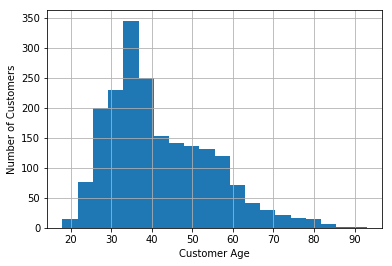

In [14]:
#plotting a histogram of Applicant AGE using the command
df['age'].hist(bins=20)
plt.xlabel('Customer Age')
plt.ylabel('Number of Customers')
plt.show()

##### From the Histogram, we can see that most of the customers are 25-60 years with a peak at 35 years. This shows bankers have targetted the customers who would be working

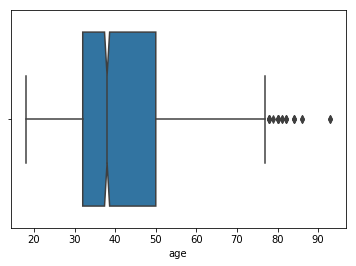

In [15]:
# we look at boxplots to understand the distribution better
sns.boxplot(x='age', data=df, notch=True)
plt.show()

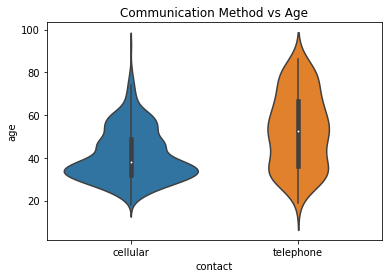

In [16]:
#Violin plot for Age vs contact

sns.violinplot(x='contact', y='age', data=df)
plt.title("Communication Method vs Age")
plt.show()

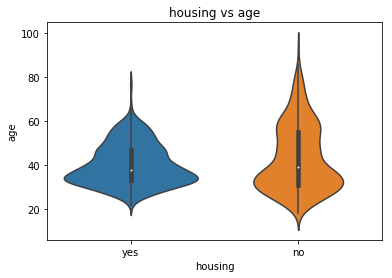

In [17]:
# With the above result we could see cellular phones are used majorly between 25 to 60 years
# & suspecting bankers would have contacted them for housing loan using cellular phones
# Violin plot for Loan vs duration

sns.violinplot(x='housing', y='age', data=df)
plt.title("housing vs age")
plt.show()

           housing
marital           
divorced  0.534884
married   0.504950
single    0.425816


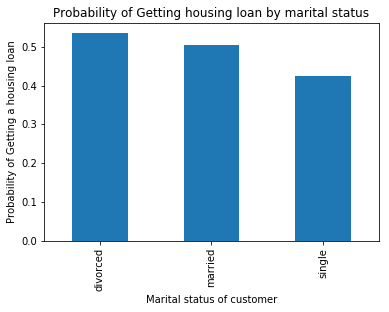

In [18]:
# Plot housing loan pivot table
pivot_table_housing = df.pivot_table(values='housing',
                       index=['marital'],
                       aggfunc=lambda x: x.map({'yes':1, 'no':0}).mean())
print(pivot_table_housing)
pivot_table_housing.plot(kind='bar')
plt.xlabel('Marital status of customer')
plt.ylabel('Probability of Getting a housing loan')
plt.title('Probability of Getting housing loan by marital status')
plt.legend().set_visible(False) 
plt.show()

##### Based on the probability we could see housing loans bought by divorced persons

## Generate two plots with the combined distribution of attributes and draw conclusions from them (in a markdown cell).

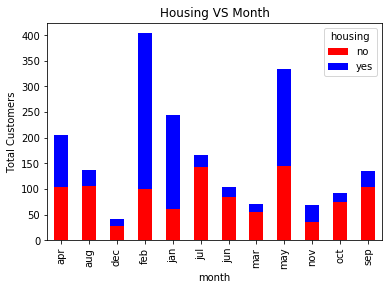

In [19]:
stacked_chart = pd.crosstab(df['month'], df['housing'])
stacked_chart.plot(kind='bar', stacked=True, color=['red', 'blue'])
plt.title("Housing VS Month")
plt.ylabel('Total Customers')
plt.show()

#### Customers who have housing / housing loan took during Feb / May month

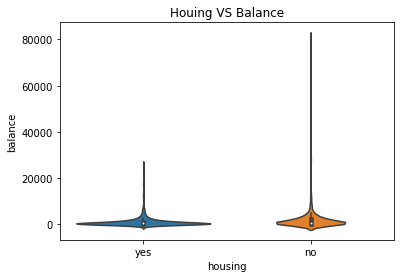

In [20]:
sns.violinplot(x='housing', y='balance',data=df)
plt.title('Houing VS Balance')
plt.show()

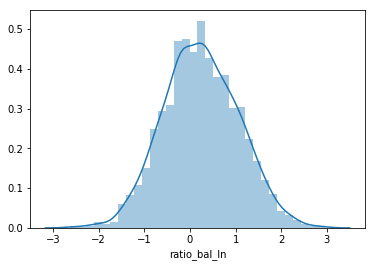

In [22]:
# Distribution of the numeric variable "ratio_bal_ln" 

sns.distplot(df.ratio_bal_ln)
plt.show()

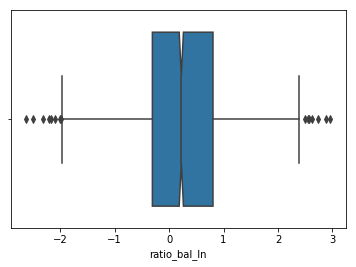

In [23]:
# Box plot for the numeric variable "ratio_bal_ln" 

sns.boxplot(x='ratio_bal_ln', data=df, notch=True)
plt.show()

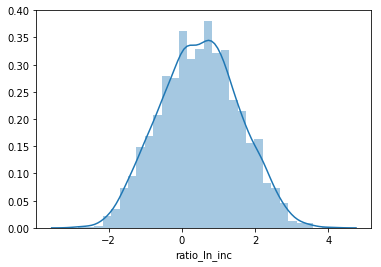

In [25]:
# Distribution of the numeric variable "ratio_ln_inc" 

sns.distplot(df.ratio_ln_inc)
plt.show()

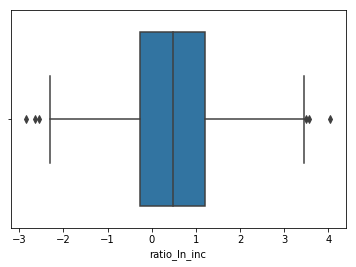

In [27]:
# Box plot for numeric variable "ratio_ln_inc" 

sns.boxplot(x='ratio_ln_inc', data=df)
plt.show()

The attribute "ratio_ln_inc" has a uniform distribution with few outliers at both the ends

### Distribution Analysis for Categorical Attributes

In [29]:
frequency_table_educational = df['education'].value_counts(ascending=True)
print('Frequency Table for education status:') 
print(frequency_table_educational)

Frequency Table for education status:
primary      217
tertiary     684
secondary    995
Name: education, dtype: int64


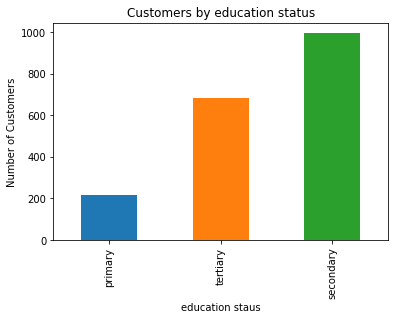

In [30]:
# Plot the frequency table for marital status
frequency_table_educational.plot(kind='bar')
plt.xlabel('education staus')
plt.ylabel('Number of Customers')
plt.title('Customers by education status')
plt.show()

##### More customers completed their Secondary Studies & least are primary

In [31]:
pivot_table_educational = df.pivot_table(values='subscribed',
                       index=['education'],
                       aggfunc=lambda x: x.map({'yes':1, 'no':0}).mean())
print(pivot_table_educational)

           subscribed
education            
primary      0.387097
secondary    0.453266
tertiary     0.578947


#### The probability of getting the customer subscribed by bank is 57.8% for customer who are tertiary. 45% secondary and 38.7% primary customers also subscribed to the bank

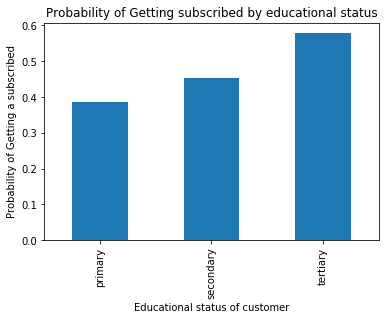

In [32]:
# Plot Educational pivot table
pivot_table_educational.plot(kind='bar')
plt.xlabel('Educational status of customer')
plt.ylabel('Probability of Getting a subscribed')
plt.title('Probability of Getting subscribed by educational status')
plt.legend().set_visible(False) # we don't need the default legend
plt.show()

In [ ]:
Let's plot contact type and the probability of getting subscribed based on contact type.

In [34]:
frequency_table_contact = df['contact'].value_counts(ascending=True)
print('Frequency Table for contact type:') 
print(frequency_table_contact)

Frequency Table for contact type:
telephone     146
cellular     1663
Name: contact, dtype: int64


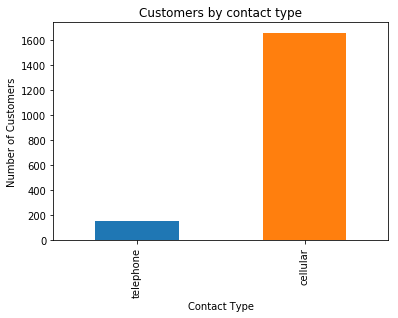

In [35]:
# Plot the frequency table for marital status
frequency_table_contact.plot(kind='bar')
plt.xlabel('Contact Type')
plt.ylabel('Number of Customers')
plt.title('Customers by contact type')
plt.show()

In [36]:
pivot_table_contact = df.pivot_table(values='subscribed',
                       index=['contact'],
                       aggfunc=lambda x: x.map({'yes':1, 'no':0}).mean())
print(pivot_table_contact)

           subscribed
contact              
cellular     0.532171
telephone    0.623288


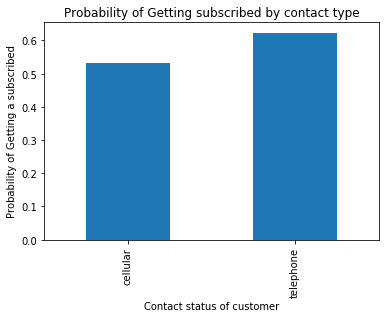

In [38]:
# Plot Contact Type pivot table
pivot_table_contact.plot(kind='bar')
plt.xlabel('Contact status of customer')
plt.ylabel('Probability of Getting a subscribed')
plt.title('Probability of Getting subscribed by contact type')
plt.legend().set_visible(False) # we don't need the default legend
plt.show()

### Generate two plots with the combined distribution of attributes and draw conclusions from them (in a markdown cell).

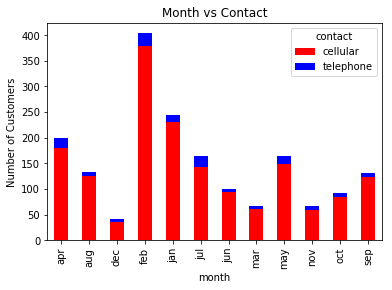

In [39]:
stacked_chart = pd.crosstab(df['month'], df['contact'])
stacked_chart.plot(kind='bar', stacked=True, color=['red', 'blue'])
plt.title("Month vs Contact")
plt.ylabel('Number of Customers')
plt.show()

#### Customers who were contacted were mostly in cellular. During the months Feb, Apr and July they were conatcted hugely.

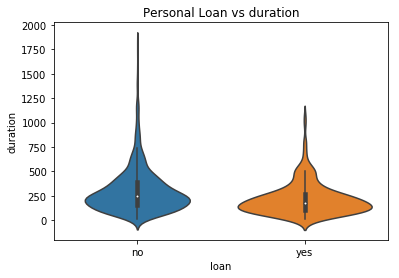

In [41]:
# Violin plot for Loan vs duration

sns.violinplot(x='loan', y='duration', data=df)
plt.title("Personal Loan vs duration")
plt.show()

The numerical attributes should be linearly separable for the the PLA algorithm for convergence.

Looking at the data so far, there doesn't seem to be any 2 obvious numerical attributes which are perfectly linearly separable.

Goal is to find the best 2 numeric attributes for the prediction

In [42]:
# Create color blobs for the target attributes
cmap = lambda x: 'blue' if x=='yes' else 'orange'
hue_subs =[]
for value in df['subscribed']:
    hue_subs.append(cmap(value))

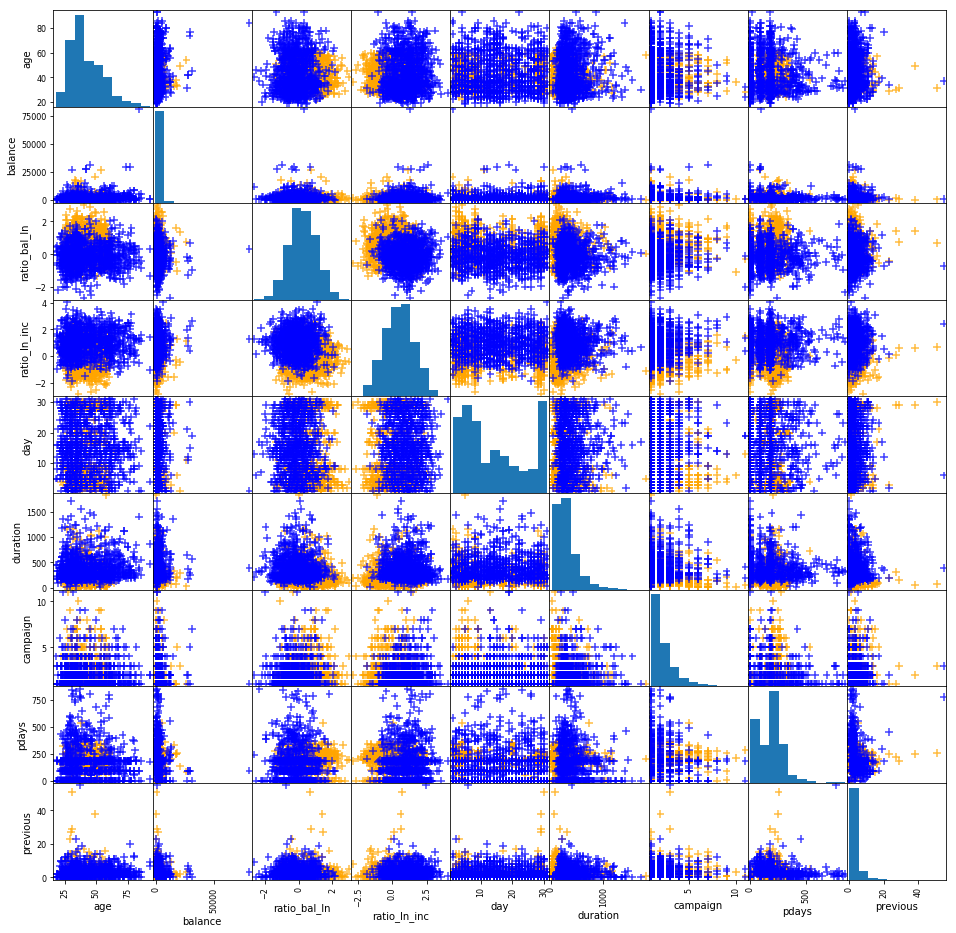

In [43]:
# Using pandas scatter matrix plot to build the pair plots
pair_plot = pd.plotting.scatter_matrix(df, c=hue_subs, figsize=(16, 16), marker='+',
                                       hist_kwds={'bins': 10}, s=60, alpha=.75)
plt.show()

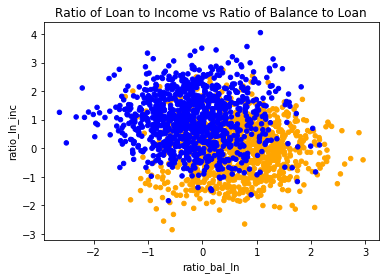

In [44]:
# Plot the scatter plot for "ratio_bal_ln" vs "ratio_ln_inc" to have a deeper look

df.plot.scatter(x='ratio_bal_ln', y='ratio_ln_inc', c=hue_subs)
plt.title('Ratio of Loan to Income vs Ratio of Balance to Loan')
plt.show()

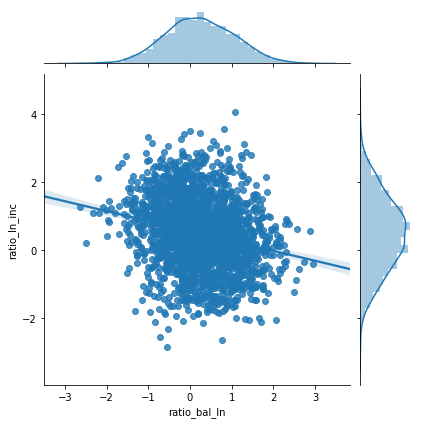

In [45]:
# Seaborn joint distribution plot between "ratio_bal_ln" vs "ratio_ln_inc" with regplot

sns.jointplot(x='ratio_bal_ln', y='ratio_ln_inc', data=df, kind='reg')
plt.show()

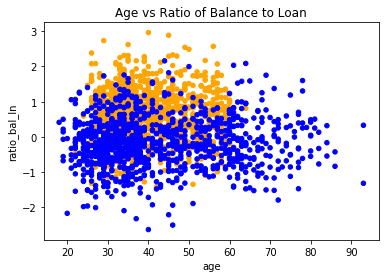

In [46]:
    # Plot the scatter plot for "age" and "ratio_bal_ln"

df.plot.scatter(x='age', y='ratio_bal_ln', c=hue_subs)
plt.title('Age vs Ratio of Balance to Loan')
plt.show()

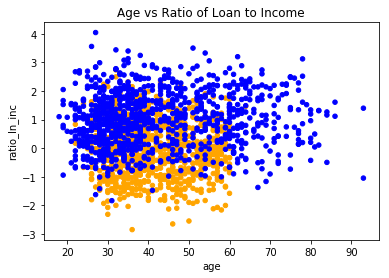

In [47]:
# Plot the scatter plot for "age" and "ratio_ln_inc"

df.plot.scatter(x='age', y='ratio_ln_inc', c=hue_subs)
plt.title('Age vs Ratio of Loan to Income')
plt.show()

From the above plots its clear that attributes "ratio_bal_ln" and "ratio_ln_inc" are the best candidates suited for the prediction. The other two options are "Age" vs "ratio_bal_ln" and  "Age" vs "ratio_ln_inc".